In [1]:
%cd ..
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, Softmax, ReLU, Softplus
from src.encapsulation import Sequential, Optim
np.random.seed(42)

/tempory/NeuralNetworksDIY


/tempory/NeuralNetworksDIY/src/encapsulation.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
batch_size = 8
X, y = load_digits(return_X_y=True, n_class=2)
y_oh = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

net = Sequential(
    Linear(64, 32),
    TanH(),
    Linear(32, 16),
    TanH(),
    Linear(16, 8),
    TanH(),
    Linear(8, 2),
    Sigmoid(),
    # Softmax(),
)


  0%|          | 0/50 [00:00<?, ?it/s]

1.0


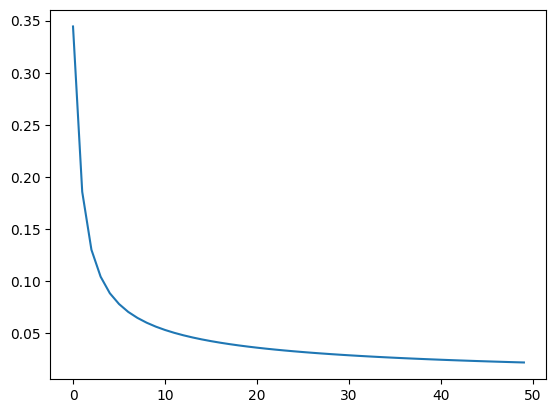

In [3]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-2)
lossList = optimizer.SGD(X, y_oh, batch_size, 50)
pd.Series(lossList).plot()
print(optimizer.score(X, y))


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='loss'>

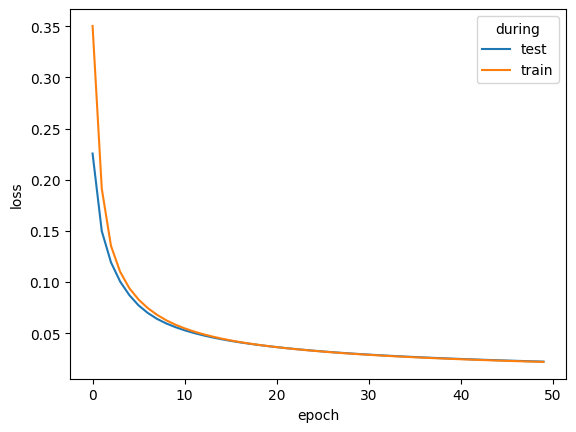

In [4]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-2)
result_df = optimizer.SGD_eval(
    X, y_oh, batch_size, 50, test_size=8, return_dataframe=True
)
loss_long_df = pd.melt(
    result_df,
    id_vars="epoch",
    value_vars=["loss_test", "loss_train"],
    value_name="loss",
    var_name="during",
).replace({"loss_test": "test", "loss_train": "train"})
sns.lineplot(loss_long_df, x="epoch", y="loss", hue="during")


0.33055555555555555


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

0    0.375
1    0.375
2    0.375
3    0.375
4    0.375
Name: score_test, dtype: float64

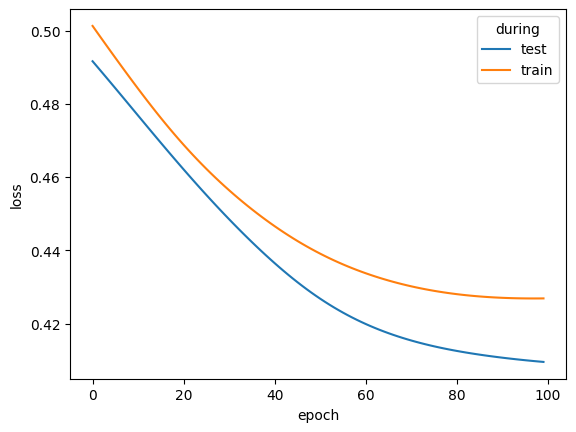

In [5]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-5)
print(optimizer.score(X, y))
result_df = optimizer.SGD_eval(X, y_oh, batch_size, 100, test_size=8, return_dataframe=True)
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during')
result_df['score_test'].head()

In [6]:
result_df

,epoch,loss_train,loss_test,score_train,score_test
0,0,0.501272,0.491629,0.335227,0.375
1,1,0.499514,0.490166,0.346591,0.375
2,2,0.497764,0.488698,0.349432,0.375
3,3,0.496022,0.487224,0.349432,0.375
4,4,0.494288,0.485745,0.360795,0.375
...,...,...,...,...,...
95,95,0.426883,0.410008,0.517045,0.625
96,96,0.426874,0.409885,0.517045,0.625
97,97,0.426871,0.409768,0.517045,0.625
98,98,0.426876,0.409654,0.519886,0.625


# Fashion MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try.  "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset

Data Description
* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.
* Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.
* The training and test data sets have 785 columns.
* The first column consists of the class labels (see above), and represents the article of clothing.
* The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix. For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide

In [2]:
def normalize_batch_image(X):
    mn = np.min(X)
    mx = np.max(X)
    X_norm = (X - mn) * (1.0 / (mx - mn))
    return X_norm

def load_data(rootdir, class_list=None, trim: float = 0.5):

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.5)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


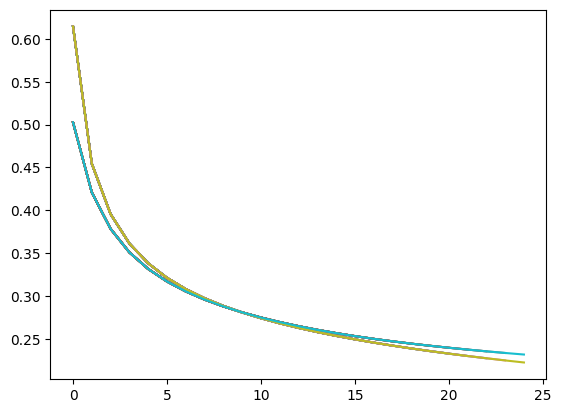

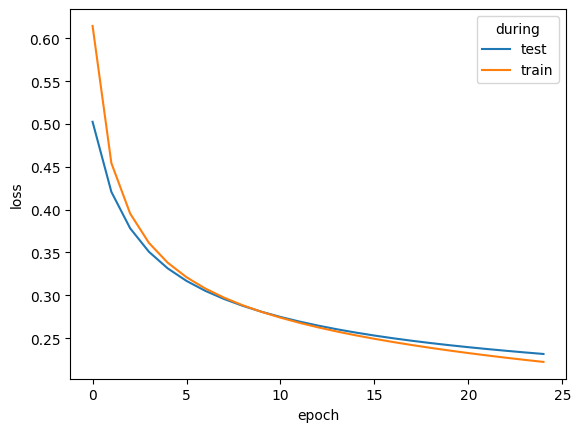

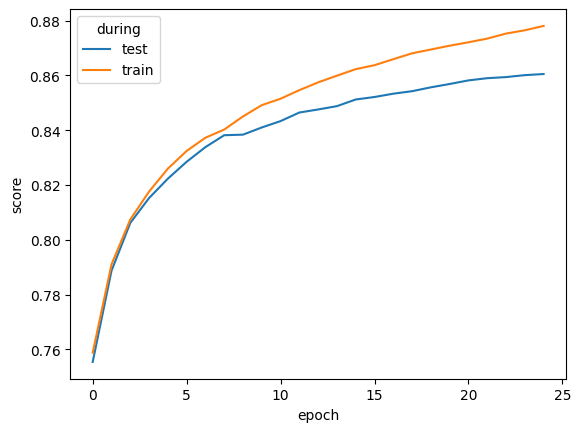

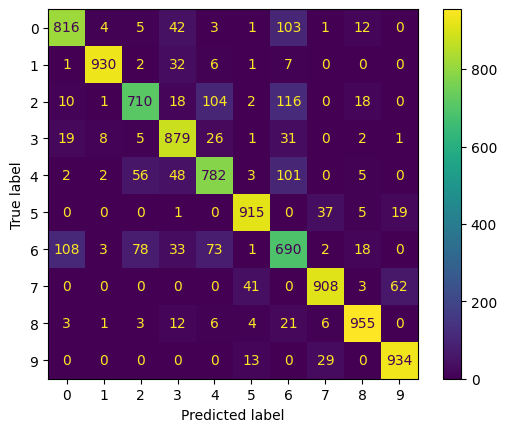

In [10]:
net = Sequential(
    Linear(784, 256, init_type='he_normal'),
    TanH(),
    Linear(256, 32, init_type='he_normal'),
    TanH(),
    Linear(32, nb_class),
    Sigmoid(),
)
fig, ax = plt.subplots()
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-3)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True, fig=fig, ax=ax )

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1))

Réseau plus complexe 

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

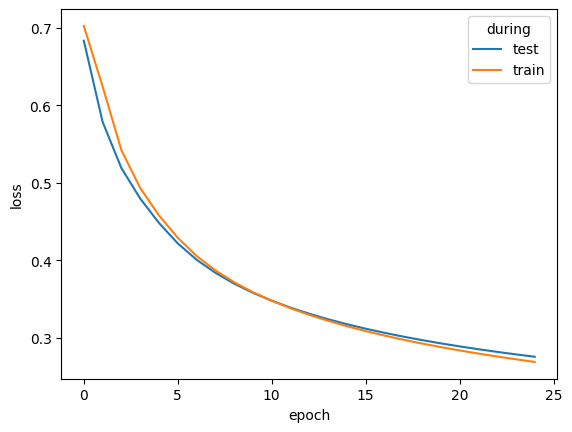

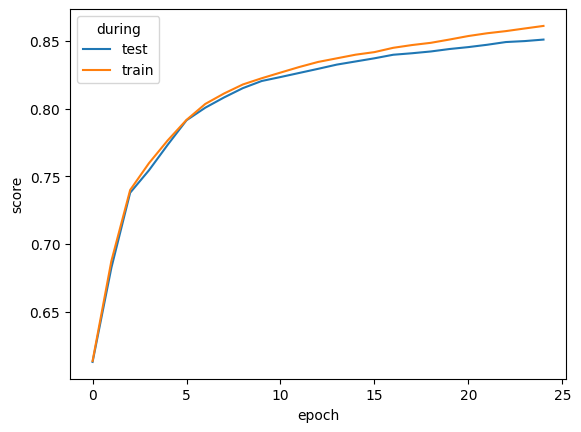

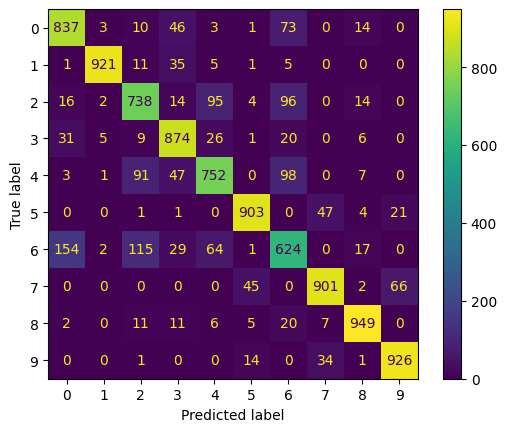

In [9]:
net = Sequential(
    Linear(784, 512),
    TanH(),
    Linear(512, 256),
    TanH(),
    Linear(256, 128),
    TanH(),
    Linear(128, 64),
    TanH(),
    Linear(64, 32),
    TanH(),
    Linear(32, nb_class),
    Sigmoid(),
)

optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=2e-4)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1))

on cap à 80% 

Avec un softmax à la fin 

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='score'>

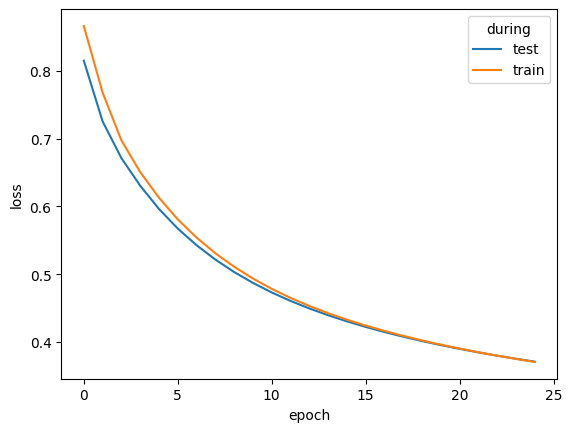

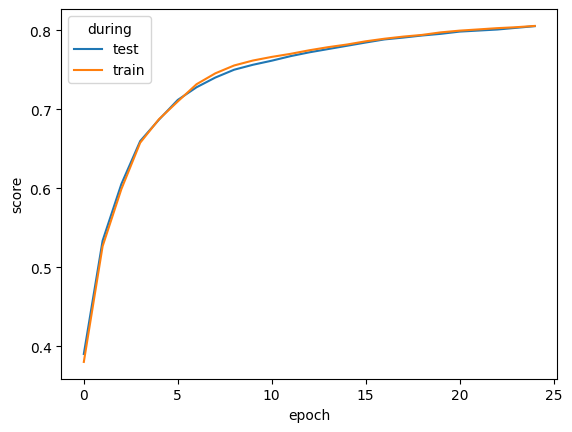

In [10]:
net = Sequential(
    Linear(784, 256),
    TanH(),
    Linear(256, 32),
    TanH(),
    Linear(32, nb_class),
    Softmax(),
)

optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-4)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

Avec des ReLUs

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='score'>

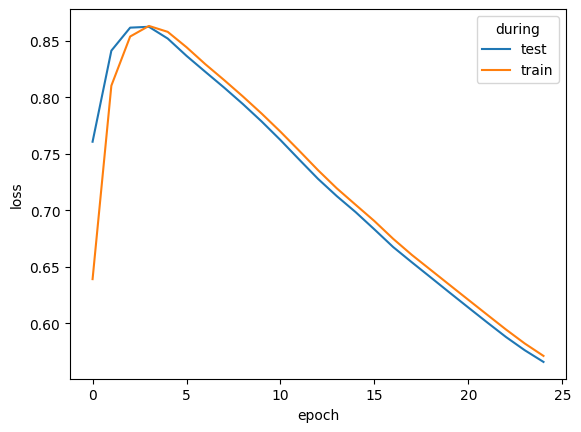

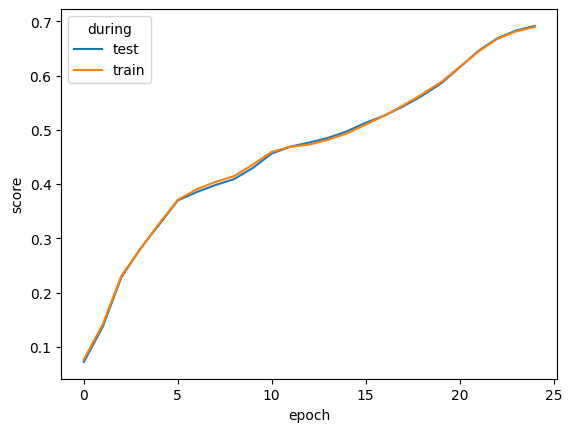

In [11]:
net = Sequential(
    Linear(784, 256),
    ReLU(),
    Linear(256, 32),
    ReLU(),
    Linear(32, nb_class),
    Sigmoid(),
)
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=2e-5)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

fonctionne très mal

# Test de l'init des poids

j'vais faire un réseau super simple pour garder l'interprétabilité des poids comme dans le TME4. Comme on sait que l'initialisation joue là dessus 

In [12]:
net = Sequential(
    Linear(784, 10, init_type='ones'),
    Sigmoid()
)
net.modules[0]._parameters['weight'] = net.modules[0]._parameters['weight'] - 0.9
net.modules[0]._parameters['bias'] = net.modules[0]._parameters['bias'] - 1
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=4e-3)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 30, test_size=0.33, return_dataframe=True)


_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)
ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1))

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

In [ ]:
class_num2_name = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
def display_weight(net):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    ax = ax.flatten()
    for i in range(10):
        p = net.modules[0]._parameters['weight'][:, i].reshape(28,28)
        p = normalize_batch_image(p)
        # p = np.exp(p)
        ax[i].imshow(p, cmap='gist_gray')
        ax[i].set_title(class_num2_name[i])
    plt.show()
display_weight(net)

normal


  0%|          | 0/30 [00:00<?, ?it/s]

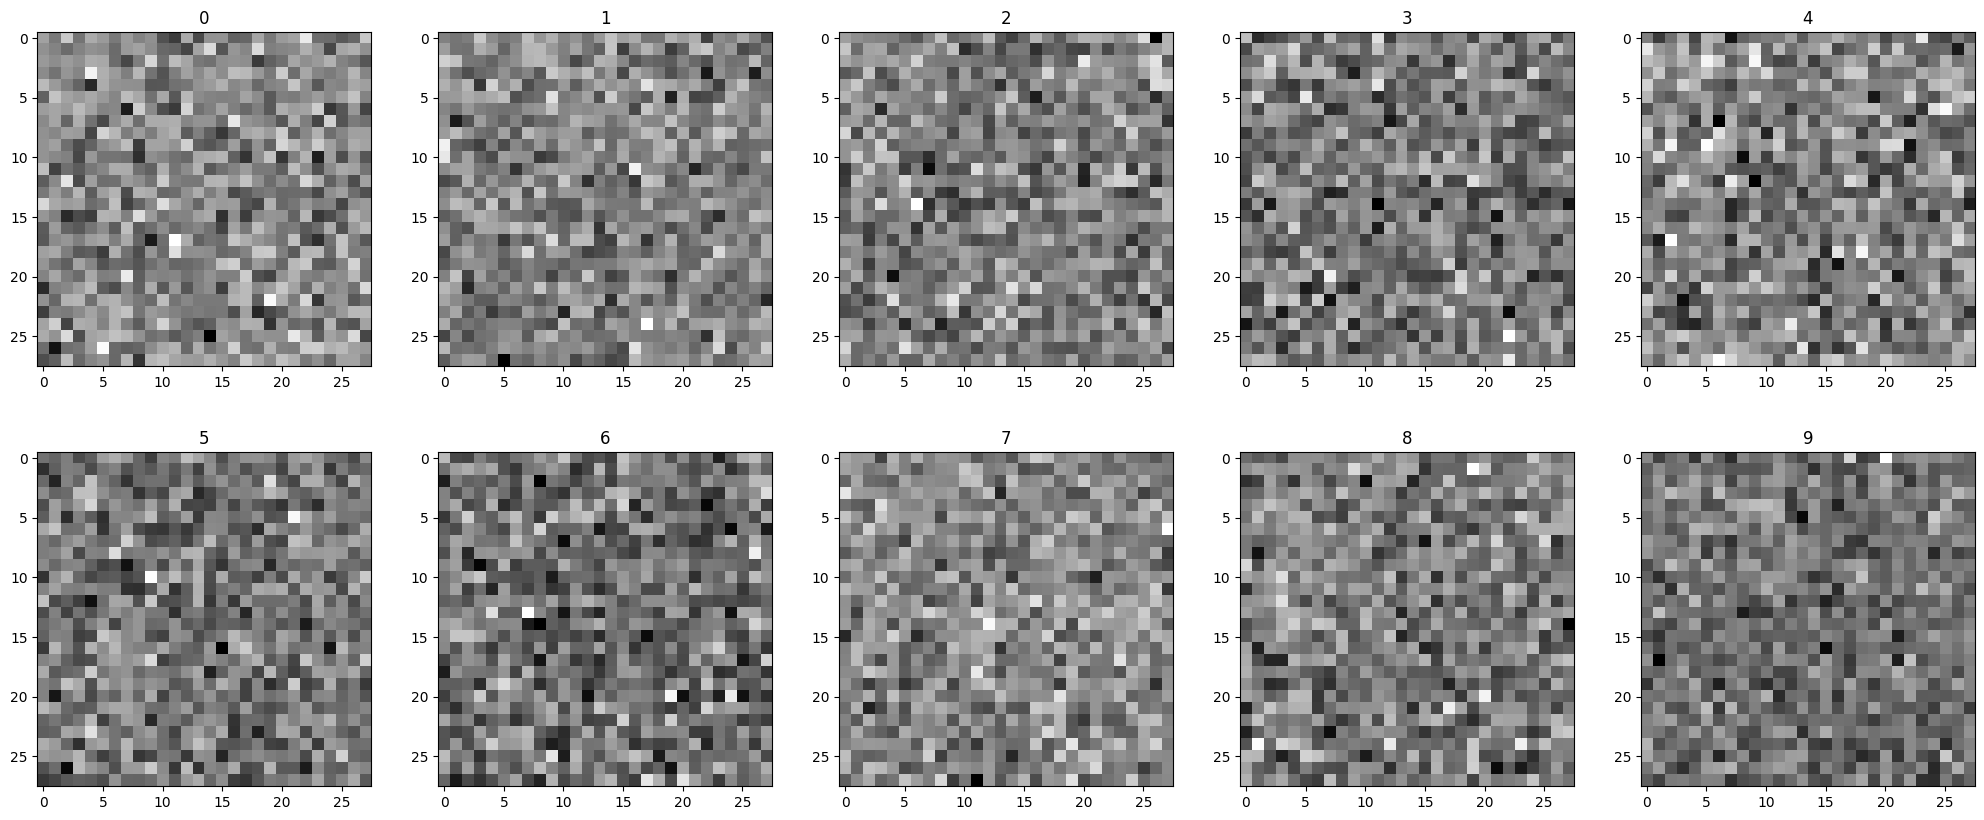

uniform


  0%|          | 0/30 [00:00<?, ?it/s]

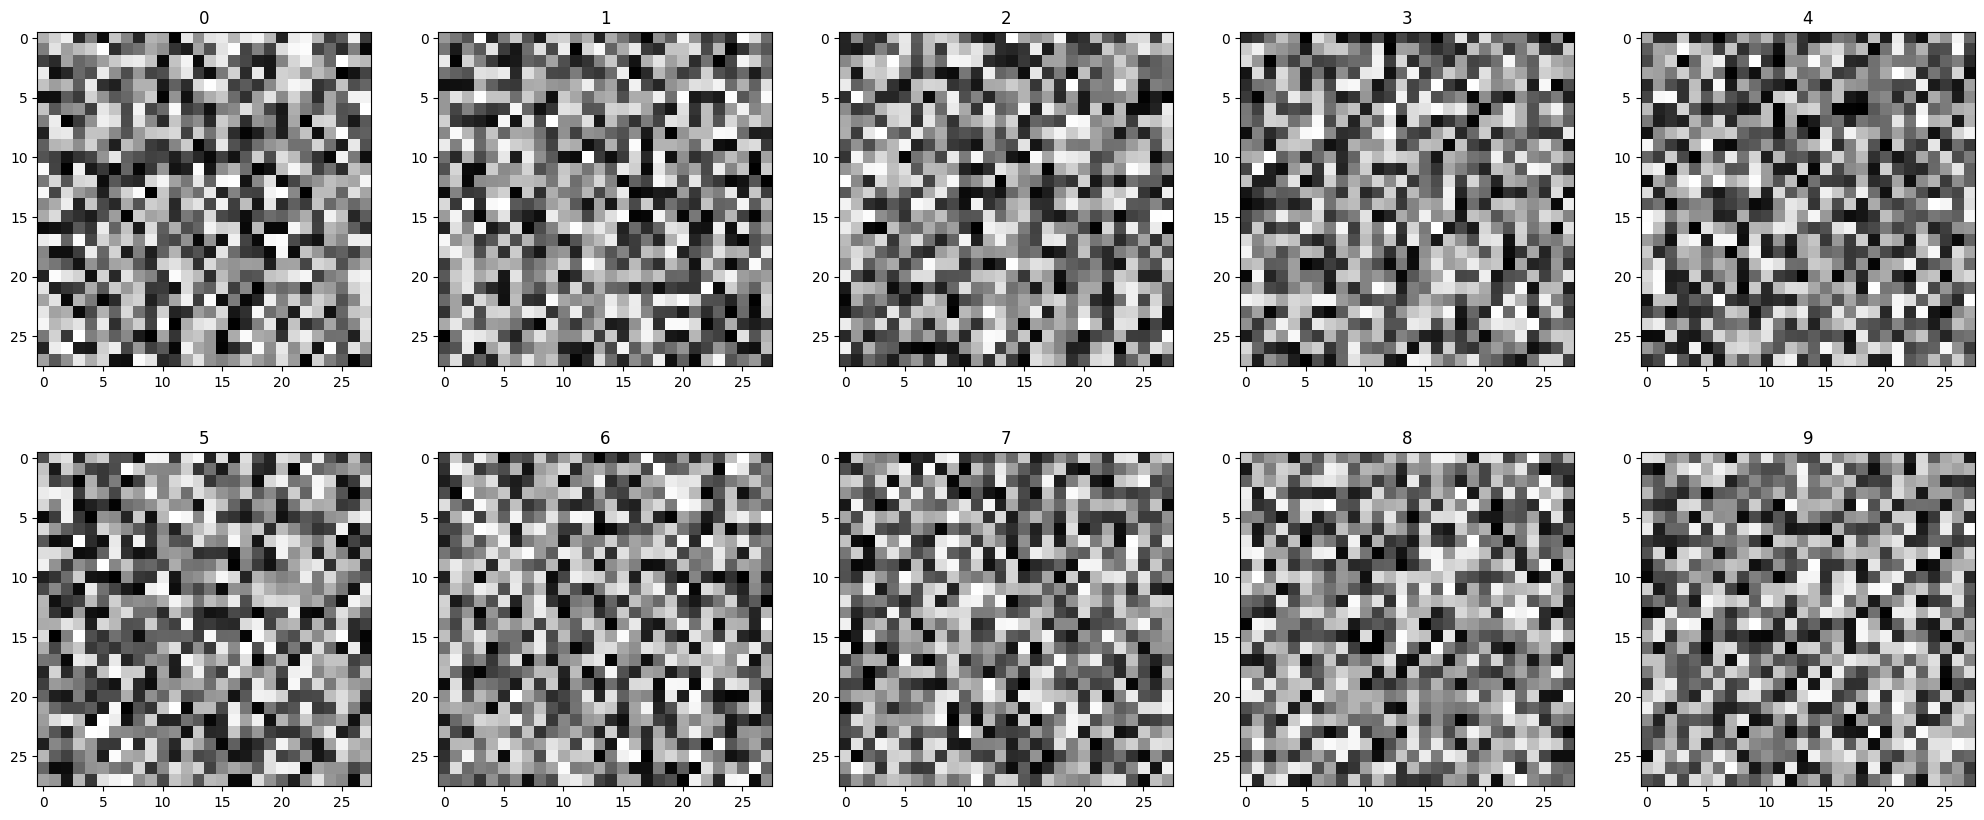

zeros


  0%|          | 0/30 [00:00<?, ?it/s]

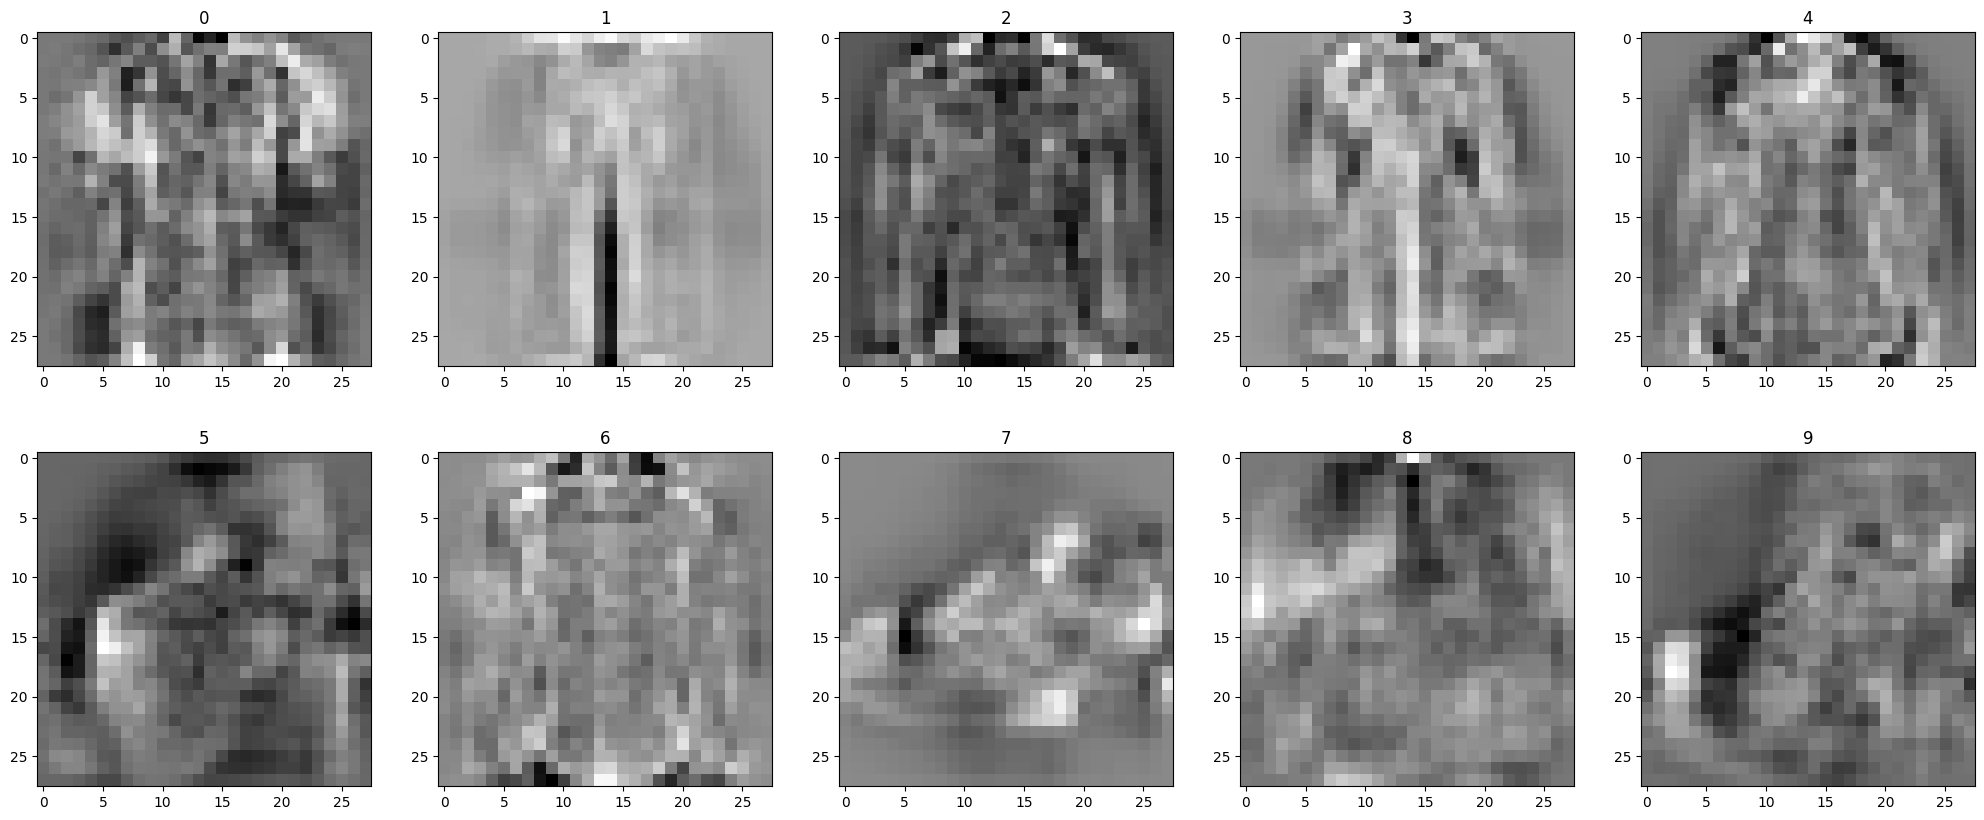

ones


  0%|          | 0/30 [00:00<?, ?it/s]

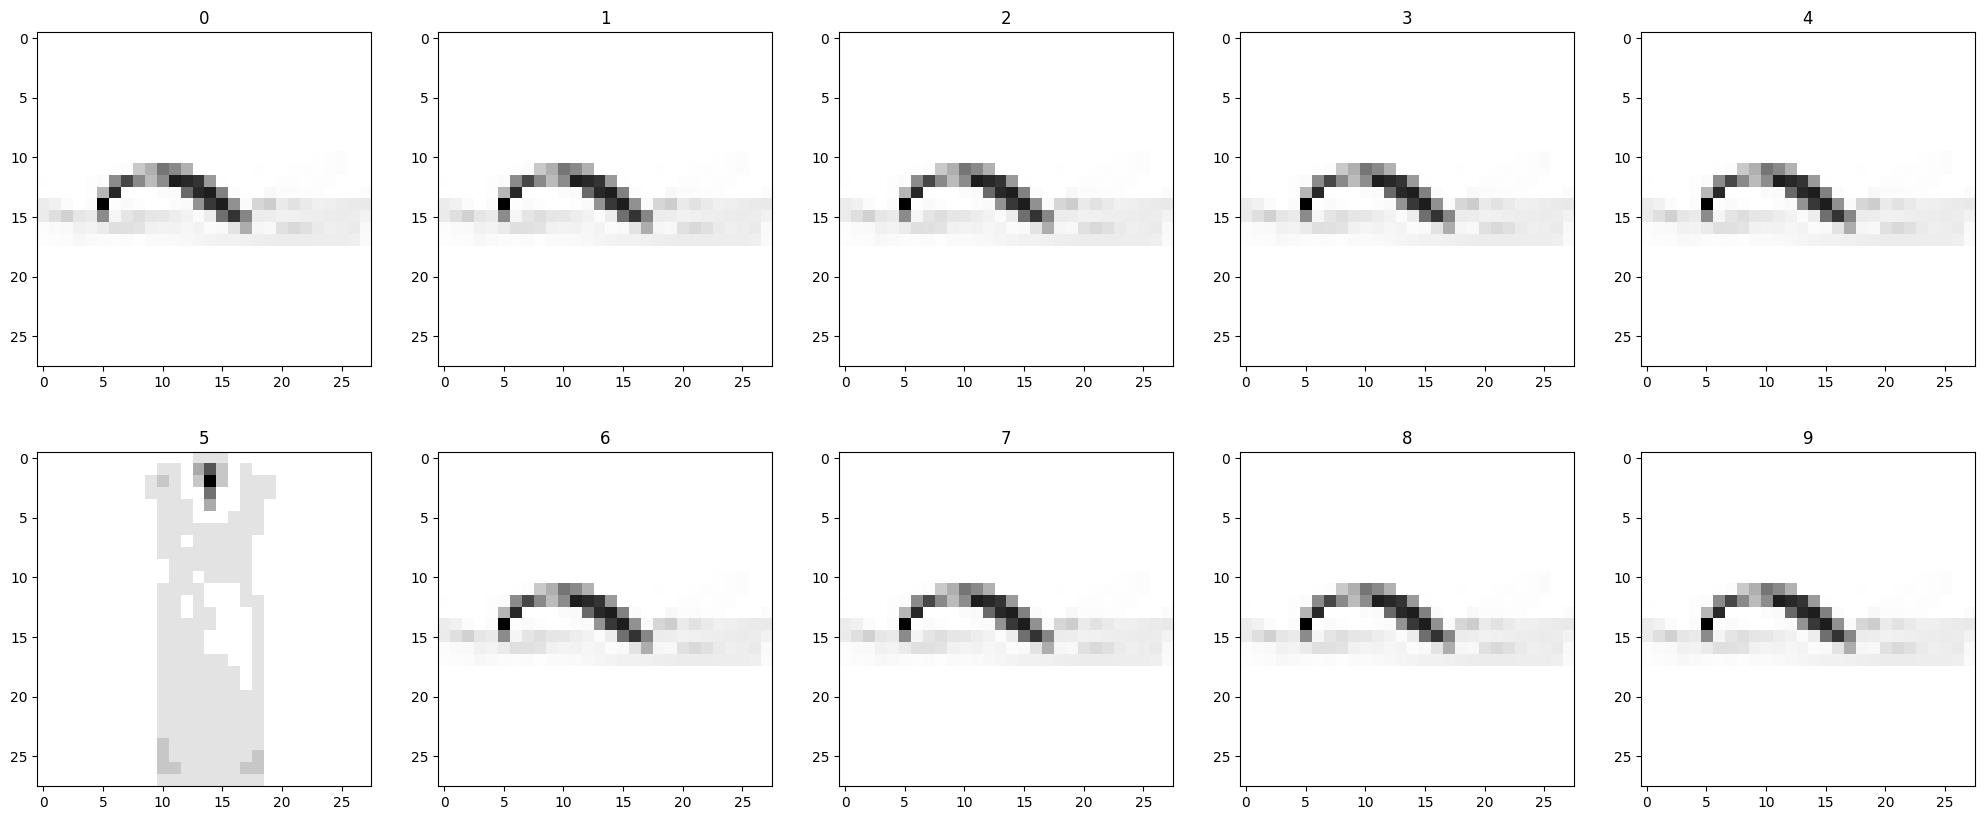

he_normal


  0%|          | 0/30 [00:00<?, ?it/s]

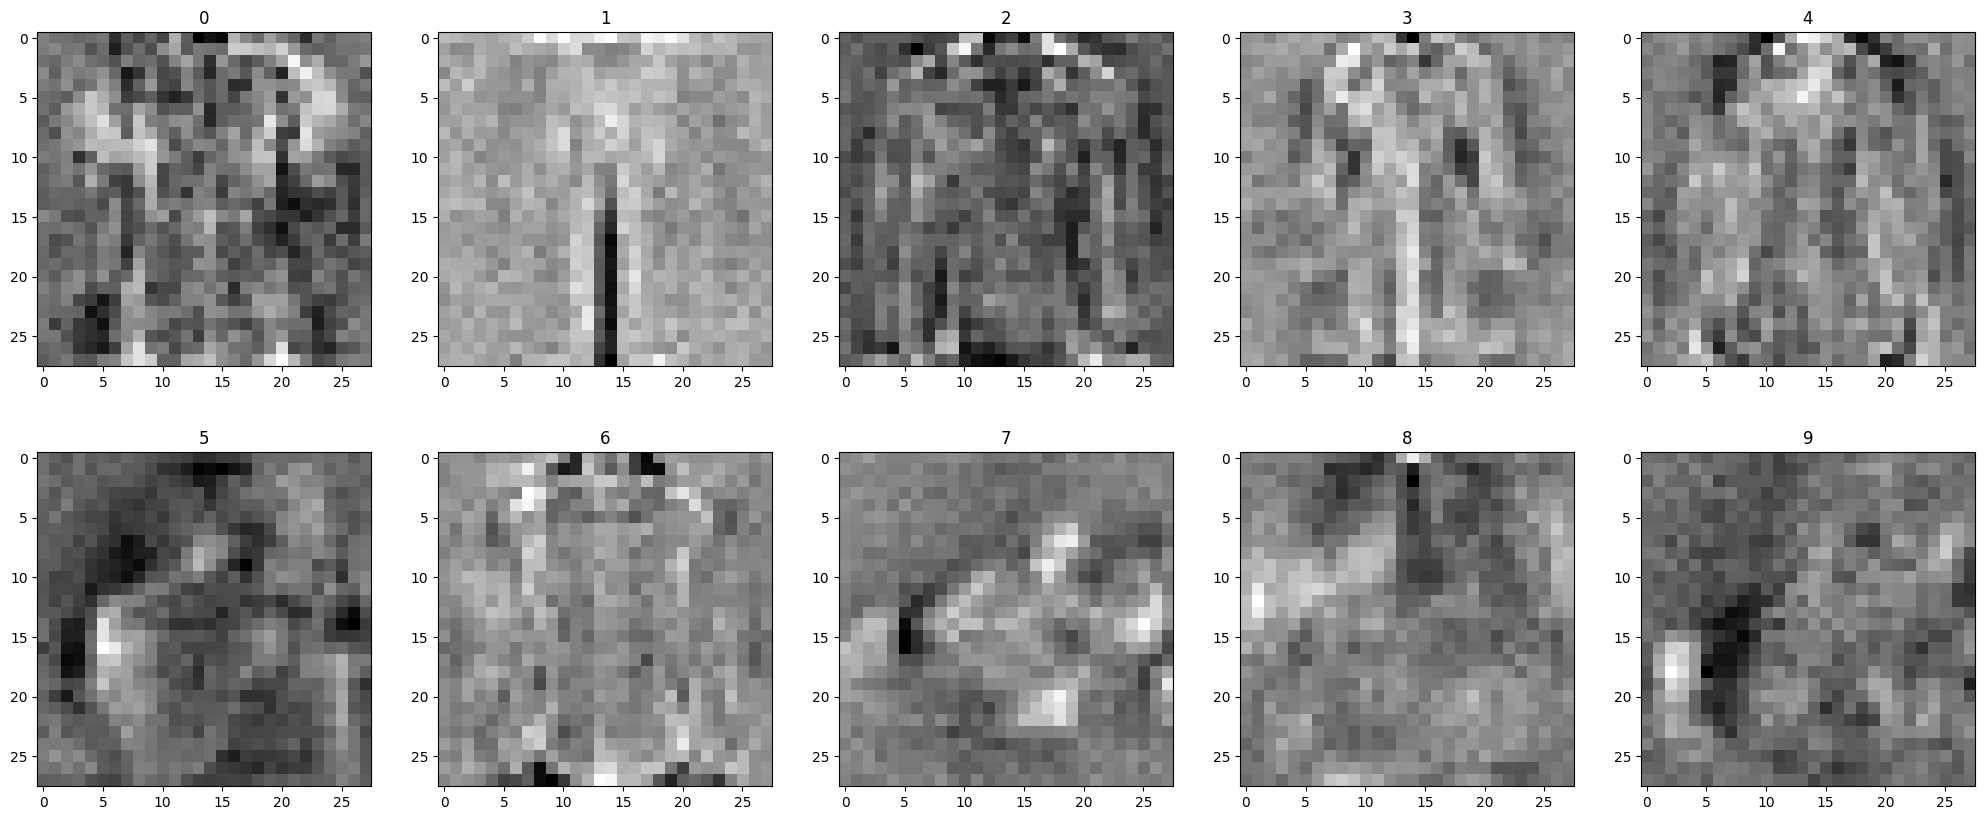

he_uniform


  0%|          | 0/30 [00:00<?, ?it/s]

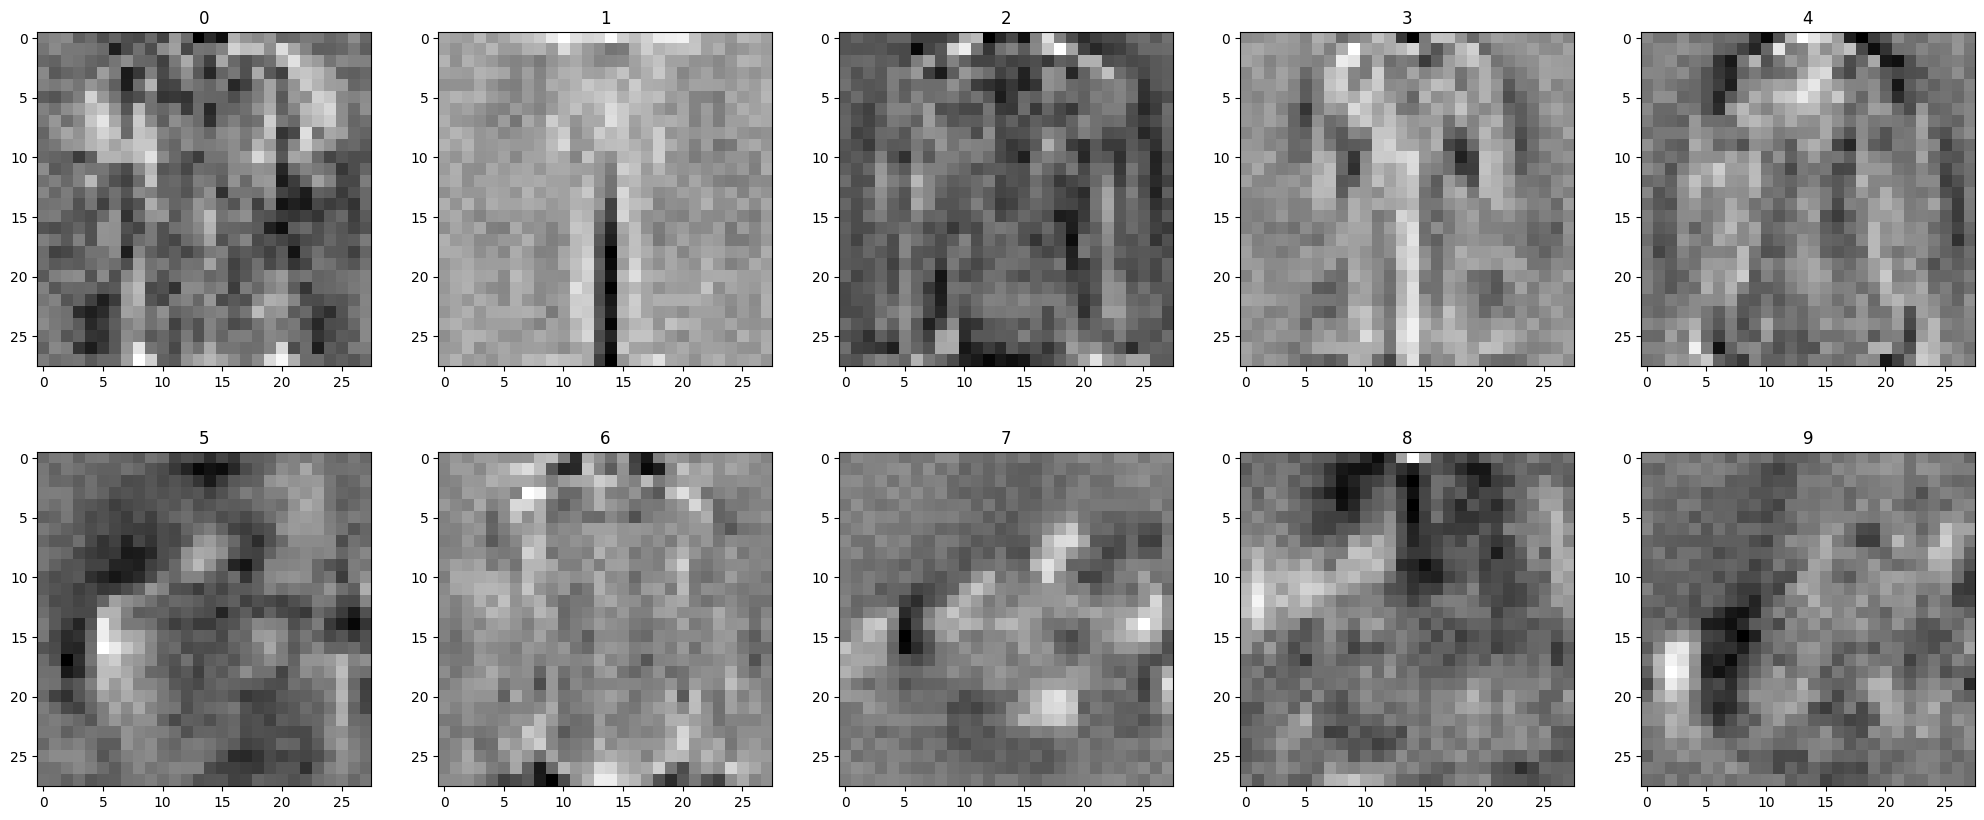

xavier_normal


  0%|          | 0/30 [00:00<?, ?it/s]

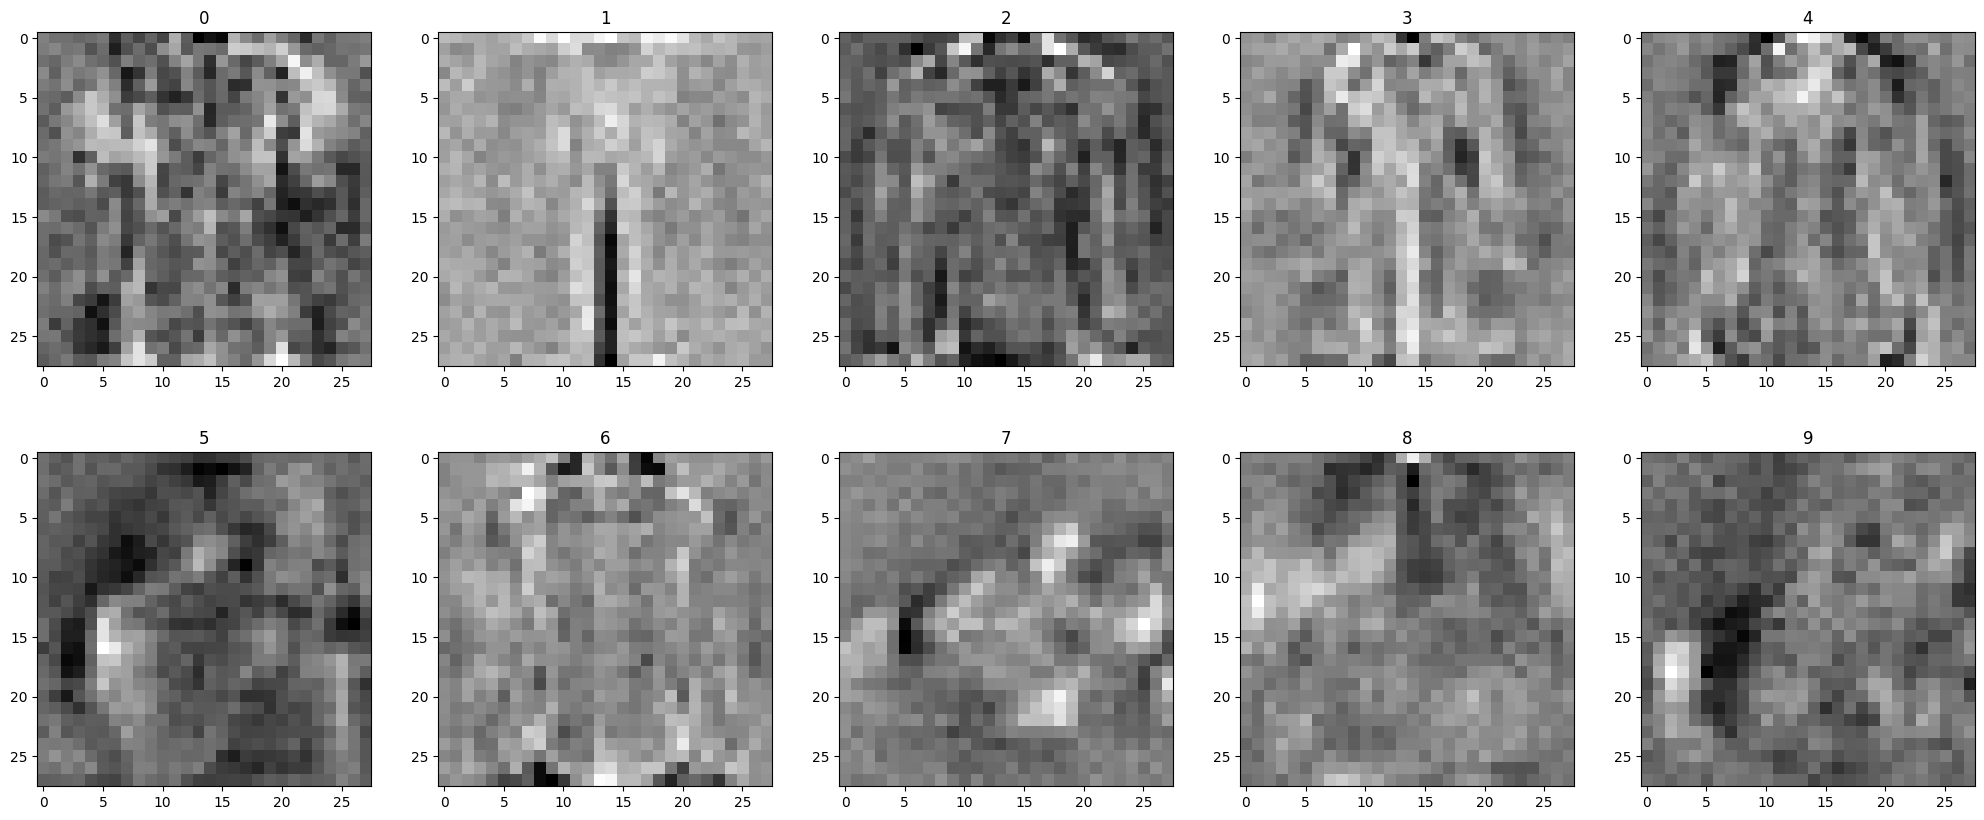

xavier_uniform


  0%|          | 0/30 [00:00<?, ?it/s]

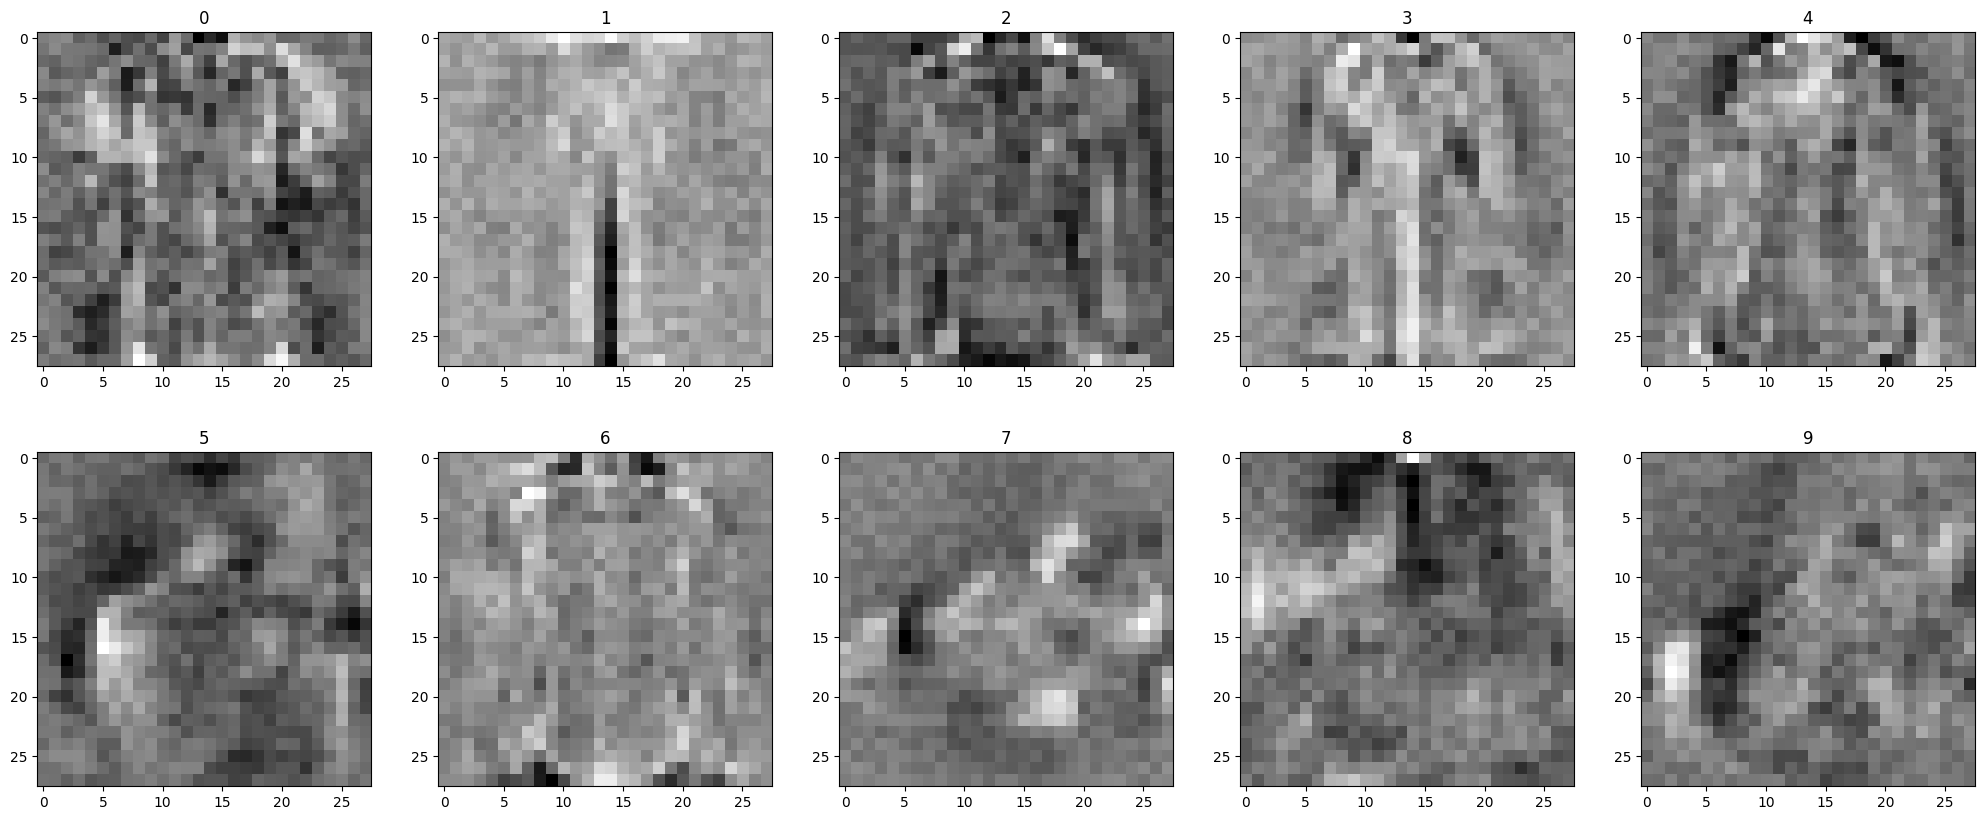

In [4]:
for init_type in ['normal', 'uniform', 'zeros', 'ones', 'he_normal', 'he_uniform', 'xavier_normal', 'xavier_uniform']:
    net = Sequential(
        Linear(784, 10, init_type=init_type),
        Sigmoid()
    )
    print(init_type)
    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=4e-3)
    result_df = optimizer.SGD(X_train, y_train_oh, batch_size, 30)
    display_weight(net)

he = xavier = bof
normal = unif = rien 
ones = wtf 
zeros = wow

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

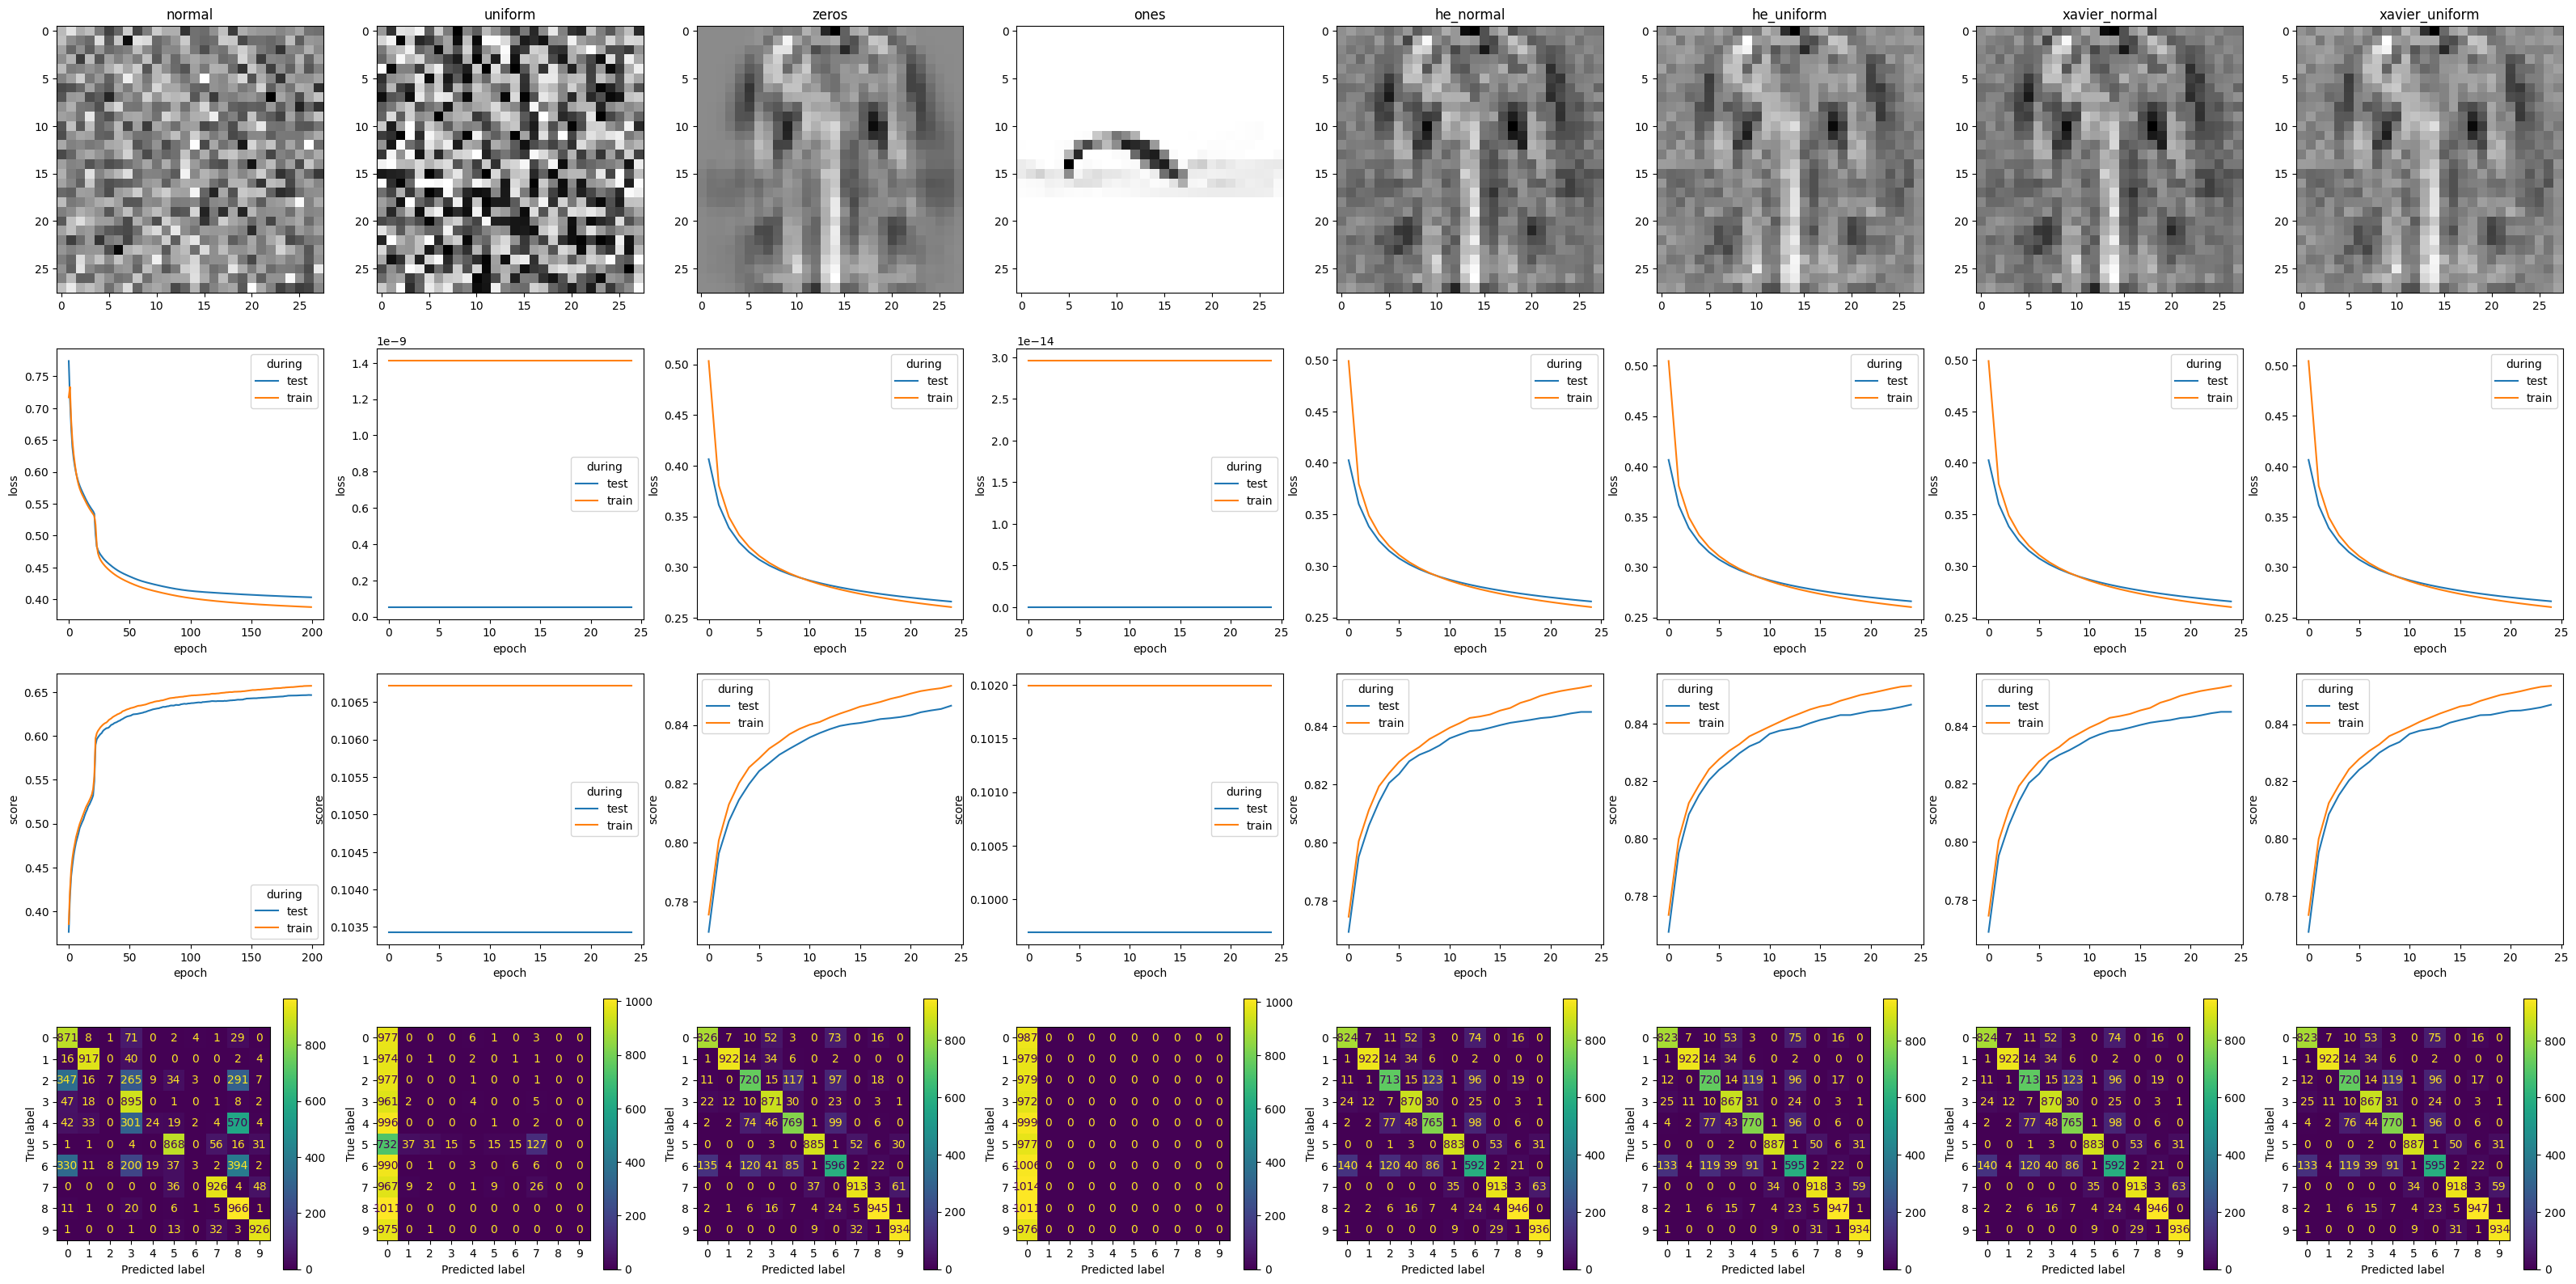

In [5]:
fig, ax = plt.subplots(ncols=8, nrows=4, figsize=(40, 20))

for i, init_type in enumerate(['normal', 'uniform', 'zeros', 'ones', 'he_normal', 'he_uniform', 'xavier_normal', 'xavier_uniform']):
    ax_col = ax[:, i]
    ax_col[0].set_title(init_type)
    
    net = Sequential(
        Linear(784, 10, init_type=init_type),
        Sigmoid()
    )
    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=4e-3)
    if init_type == 'normal':
        epoch = 200
    else:
        epoch = 25
    result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, epoch, test_size=0.33, return_dataframe=True)

    p = net.modules[0]._parameters['weight'][:, 3].reshape(28,28)
    p = normalize_batch_image(p)
    ax_col[0].imshow(p, cmap='gist_gray')

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[1])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax_col[2])
    
    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[3])
fig.savefig('reports/init_type.pdf', dpi=600)

# Effet de la learning rate